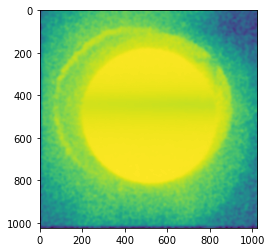

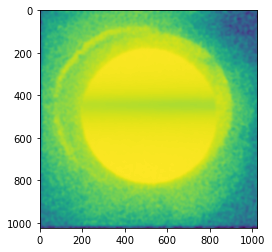

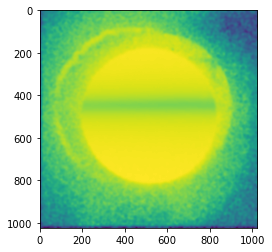

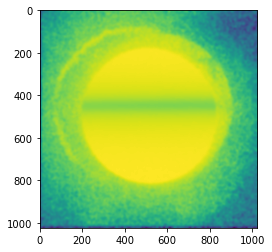

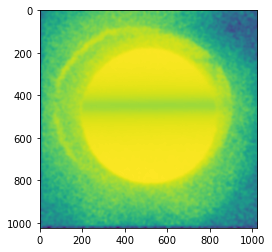

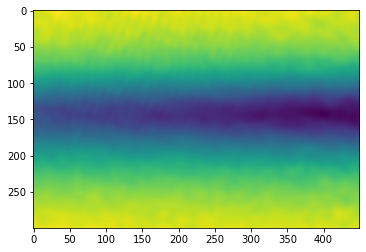

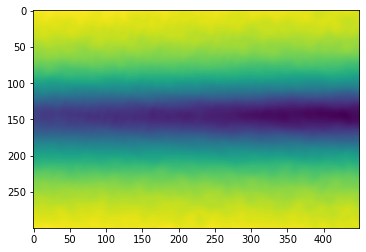

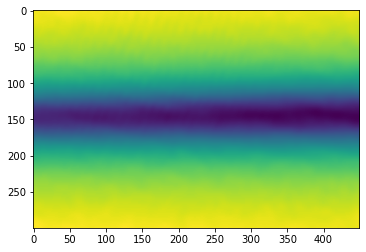

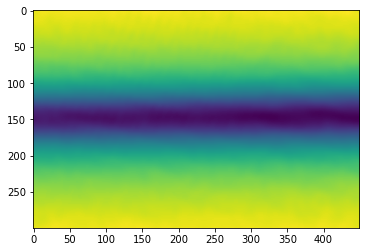

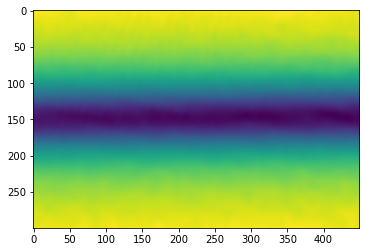

In [1]:
#open image

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as spnd
import scipy.interpolate as spi
import scipy.signal as sps


data=fits.open('run15Folder/run15_absorptionSignalImages.fits')[0].data.astype(float)
data[data>1.0]=1.0
data[data<0.0]=0.0
voltArr=np.asarray([-0.88  , -0.8675, -0.855  ,-0.8425 ,-0.83  ] )

xBounds=[300,750]
yBounds=[300,600]



images=[]
for image in data:
  image=spnd.gaussian_filter(image,5)
  images.append(image)
  plt.imshow(image)
  plt.show()
imagesCropped=[]
for image in images:
  imagesCropped.append(image[yBounds[0]:yBounds[1],xBounds[0]:xBounds[1]])
for image in imagesCropped:
    plt.imshow(image)
    plt.show()


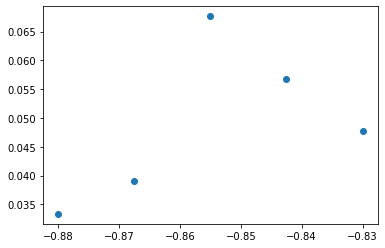

In [2]:
signalArr=np.asarray([np.mean(image) for image in imagesCropped])
signalArr=1-signalArr
plt.scatter(voltArr,signalArr)
plt.show()
imageMax=imagesCropped[np.argmax(signalArr)]

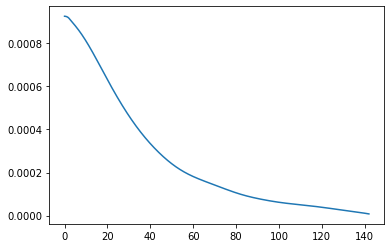

In [10]:
#construct the inverse abel transform of our data
# %matplotlib tk




def construct_Symmetric_Half_Signal(signal):
  filterWindow=2*((len(signal)//3)//2)+1
  peakPixel=np.argmax(sps.savgol_filter(signal,filterWindow,2)) 
  signalL,signalR=np.array_split(signal,[peakPixel])
  signalL=np.flip(signalL)
  signalR=signalR[:len(signalL)]
  signal_y=(signalL+signalR)/2
  return signal_y
def close_Symmetric_Top(pArr,signal_r):
  pArr=np.append(-np.flip(pArr),pArr)
  signal_r=np.append(np.flip(signal_r),signal_r)

  rbfFit=spi.RBFInterpolator(pArr[:,np.newaxis],signal_r)
  pArr=np.linspace(0,pArr[-1],len(signal_r)//2)
  signal_r=rbfFit(pArr[:,np.newaxis])
#   plt.plot(pArr[:100],signal_r[:100])
#   plt.show() 
  return pArr,signal_r
def inverse_Abel_Transform(signal_y):
  pArr=np.arange(0,len(signal_y))
  signal_yGrad=np.gradient(signal_y,pArr)
  numPointsDense=2_000
  pArr_Dense=np.linspace(0.0,1,numPointsDense)*pArr[-1]
  signal_yGrad_Dense=spi.interp1d(pArr,signal_yGrad)(pArr_Dense)

  signal_r=[]
  pList_r=[]
  integralOffset=1
  integralStartPixel=2
  integralStart=np.argmax(pArr_Dense>integralStartPixel)
  integralEnd=integralStart*2
  for i in range(integralStart,len(signal_yGrad_Dense)-integralEnd):
    result=-(1/np.pi)*np.trapz(signal_yGrad_Dense[i+integralOffset:]/np.sqrt((pArr_Dense[i+integralOffset:])**2-pArr_Dense[i]**2),x=pArr_Dense[i+integralOffset:])
    signal_r.append(result)
    pList_r.append(pArr_Dense[i])
  pArr,signal_r=close_Symmetric_Top(pList_r,signal_r)
  return pArr,signal_r
def transform_To_Radial_Signal(signal):
  #signal must be an array of the signal at each pixel. It should encompass a range between nearly the beginnign
  #and end of the data. Must be float values, not integers as images often are
  assert isinstance(signal,np.ndarray)
  assert len(signal.shape)==1
  assert signal.dtype==np.float64
  signal_y=construct_Symmetric_Half_Signal(signal)
  pArr,signal_r=inverse_Abel_Transform(signal_y)  
  return pArr,signal_r
image=imageMax


columnWidth=100
numColumns=image.shape[1]//columnWidth +1
columnImages=[image[:,i*columnWidth:(i+1)*columnWidth] for i in range(numColumns)]
# for columnImage in columnImages[:1]:
columnImage=columnImages[0]
signal=1-np.mean(columnImage,axis=1)
pArr=np.arange(0,len(signal))
  
# # plt.plot(signalL)
# # plt.plot(signalR)
# # plt.plot(pArr,signal_yGrad)
pArr,signal_r=transform_To_Radial_Signal(signal)
# plt.plot(signal_r)
# plt.plot(pArr,signal_y/200)

# plt.axvline(x=peakPixel)
plt.plot(pArr,signal_r)
plt.show()

In [4]:
import scipy.ndimage as spnd
imageMax=imagesCropped[2]
imageMax=spnd.gaussian_filter(imageMax,5)
imageBinned=np.split(imageMax,10,axis=1)
verticalSignalList=[1-np.mean(column,axis=1) for column in imageBinned]
for verticalSignal in verticalSignalList:
  print(np.max(verticalSignal))
#   plt.plot(verticalSignal)
#   plt.show()
# temp=[]
# for i in range(imageMax.shape[1]):
#   signal=imageMax[:,i]
#   temp.append(np.mean(signal))
# plt.plot(temp) 


0.11472102656611105
0.11649018879441775
0.11707453567202386
0.11840422099229608
0.11910488884664372
0.11988599742399053
0.12159448554059005
0.1223577310930799
0.1225719137460457
0.12283849693105975


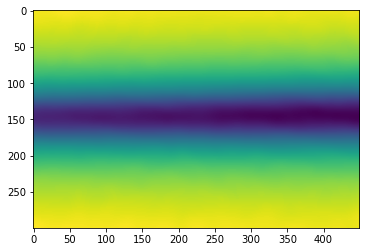

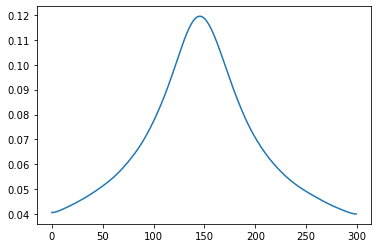

In [5]:
import scipy.ndimage as spnd
imageMax=imagesCropped[2]
imageMax=spnd.gaussian_filter(imageMax,5)

plt.imshow(imageMax)
plt.show()
verticalSignal=1-np.mean(imageMax,axis=1)
plt.plot(verticalSignal)
plt.show()

5


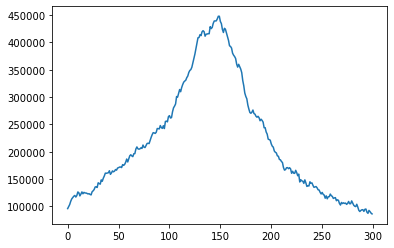

In [6]:
file=fits.open('run15Folder/run15_darkImages.fits')[0]
background=file.data

data=fits.open('run15Folder/run15_flowImages.fits')[0].data.astype(float)
data=data-background
voltArr=np.asarray([-0.88  , -0.8675, -0.855  ,-0.8425 ,-0.83  ] )
images=[image for image in data]
xBounds=[400,600]
yBounds=[300,600]
print(len(data))
imagesCropped=[]
for image in data:
  imagesCropped.append(image[yBounds[0]:yBounds[1],xBounds[0]:xBounds[1]])


# for image in imagesCropped:
#     plt.imshow(image)
#     plt.show()

deltaImage=-(imagesCropped[2]-imagesCropped[0])
verticalSignal=np.sum(deltaImage,axis=1)
plt.plot(verticalSignal)
plt.show()

5


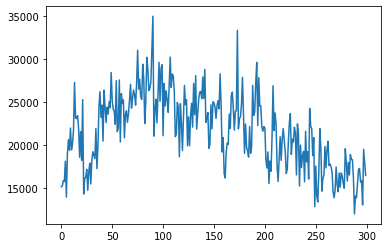

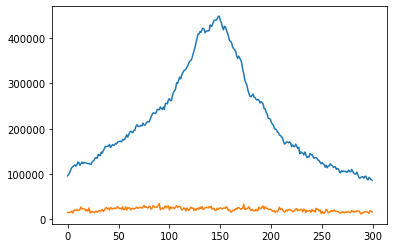

In [7]:
data=fits.open('run15Folder/run15_noFlowImages.fits')[0].data.astype(float)
data=data-background
voltArr=np.asarray([-0.88  , -0.8675, -0.855  ,-0.8425 ,-0.83  ] )
images=[image for image in data]
xBounds=[400,600]
yBounds=[300,600]
print(len(data))
imagesCropped=[]
for image in data:
  imagesCropped.append(image[yBounds[0]:yBounds[1],xBounds[0]:xBounds[1]])


# for image in imagesCropped:
#     plt.imshow(image)
#     plt.show()

deltaImageNoFlow=-(imagesCropped[2]-imagesCropped[0])
verticalSignalNoFlow=np.sum(deltaImageNoFlow,axis=1)
plt.plot(verticalSignalNoFlow)
plt.show()

plt.plot(verticalSignal)
plt.plot(verticalSignalNoFlow)
plt.show()